In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import glob
import matplotlib as mpl
import matplotlib.font_manager as fm

## Set Helvetica font
fe = fm.FontEntry(
    fname = '../HelveticaFont/Helvetica.ttf',
    name = 'Helvetica')
fm.fontManager.ttflist.insert(0, fe) # or append is fine
mpl.rcParams['font.family'] = fe.name # = 'your custom ttf font name'

In [2]:
files = sorted(glob.glob('*/*/*/*.csv'))
files

['004/01.029/A8C/20230419-schwalbe_fourU_A8C_0Murea_20C_scan.csv',
 '004/01.029/A8C/20230419-schwalbe_fourU_A8C_0Murea_259nm.csv',
 '004/01.029/A8C/20230419-schwalbe_fourU_A8C_0Murea_300nm.csv',
 '004/01.029/A8C/20230419-schwalbe_fourU_A8C_0Murea_85C_scan.csv',
 '004/01.029/A8C/20230419-schwalbe_fourU_A8C_7Murea_20C_scan.csv',
 '004/01.029/A8C/20230419-schwalbe_fourU_A8C_7Murea_259nm.csv',
 '004/01.029/A8C/20230419-schwalbe_fourU_A8C_7Murea_300nm.csv',
 '004/01.029/A8C/20230419-schwalbe_fourU_A8C_7Murea_85C_scan.csv',
 '004/01.029/A8C/20230419-schwalbe_fourU_A8C_7Murea_rev_tempgrad_CDspectra.csv',
 '004/01.029/A8C/20230419-schwalbe_fourU_A8C_7Murea_rev_tempgrad_TM.csv',
 '004/01.029/WT/20230418-schwalbe_fourU_WT_0Murea_20C_scan.csv',
 '004/01.029/WT/20230418-schwalbe_fourU_WT_0Murea_258nm.csv',
 '004/01.029/WT/20230418-schwalbe_fourU_WT_0Murea_300nm.csv',
 '004/01.029/WT/20230418-schwalbe_fourU_WT_7Murea_258nm.csv',
 '004/01.029/WT/20230418-schwalbe_fourU_WT_7Murea_300nm.csv']

In [3]:
def plot_CD(cd_300_a, cd_259_a, cd_300_b, cd_259_b, savefile):
    bkg = pd.read_csv(cd_300_a, sep = ',', skiprows=16, usecols = [0, 1], header = None)
    bkg = bkg[pd.to_numeric(bkg[0], errors='coerce').notnull()].astype(float)

    data = pd.read_csv(cd_259_a, sep = ',', skiprows=16, usecols = [0, 1], header = None)
    data = data[pd.to_numeric(data[0], errors='coerce').notnull()].astype(float)

    bkg_u = pd.read_csv(cd_300_b, sep = ',', skiprows=16, usecols = [0, 1], header = None)
    bkg_u = bkg_u[pd.to_numeric(bkg_u[0], errors='coerce').notnull()].astype(float)

    data_u = pd.read_csv(cd_259_b, sep = ',', skiprows=16, usecols = [0, 1], header = None)
    data_u = data_u[pd.to_numeric(data_u[0], errors='coerce').notnull()].astype(float)


    data[1] = data[1] - bkg[1]
    data_u[1] = data_u[1] - bkg_u[1]

    data['filt'] = savgol_filter(data[1], window_length = 24, polyorder = 2)
    data_u['filt'] = savgol_filter(data_u[1], window_length = 24, polyorder = 2)

    fs = 200 # sample rate of 200Hz
    data['deriv'] = savgol_filter(data[1], window_length = 24, polyorder = 2, deriv = 1, delta = 1/fs)
    data_u['deriv'] = savgol_filter(data_u[1], window_length = 24, polyorder = 2, deriv = 1, delta = 1/fs)

    peak = data.sort_values('deriv').head(5)[0].mean()
    peak_u = data_u.sort_values('deriv').head(5)[0].mean()
    print(peak, peak_u)
    fig, ax = plt.subplots(2, figsize = (4, 4), sharex = True)
    ax[0].axvline(peak, color = 'gray', lw = 1, alpha = 0.5)
    ax[0].axvline(peak_u, color = 'darkred', lw = 1, alpha = 0.5)
    ax[0].scatter(data[0], data[1], s = 7, color = 'gray', label = '0 M urea')
    ax[0].scatter(data_u[0], data_u[1], s = 7, color = 'darkred', label = '7 M urea')
    ax[0].plot(data[0], data['filt'], color = 'gray')
    ax[0].plot(data_u[0], data_u['filt'], color = 'darkred')
    ax[0].set_ylabel('CD (mdeg)')
    
    
    fs = 200 # sample rate of 200Hz
    y_filtered_deriv = savgol_filter(data[1], window_length = 24, polyorder = 2, deriv = 1, delta = 1/fs)
    y_filtered_deriv_u = savgol_filter(data_u[1], window_length = 24, polyorder = 2, deriv = 1, delta = 1/fs)

    ax[1].axvline(peak, color = 'gray', lw = 1, alpha = 0.5)
    ax[1].axvline(peak_u, color = 'darkred', lw = 1, alpha = 0.5)
    ax[1].plot(data[0], data['deriv'], color = 'gray', label = '0 M urea')
    ax[1].plot(data_u[0], data_u['deriv'], color = 'darkred', label = '7 M urea')
    ax[1].set_xlabel('Temperature (°C)')
    ax[1].set_ylabel('CD, 1st Derivative')
    plt.legend(frameon = False)
    plt.tight_layout()
    plt.savefig(savefile)
    plt.show()

53.14 38.142


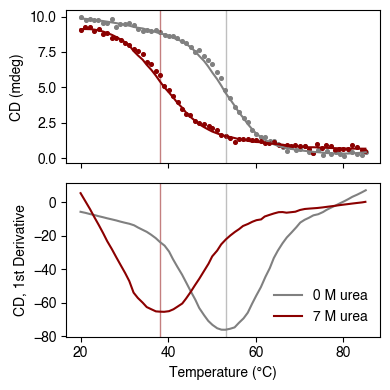

In [4]:
plot_CD(files[2], files[1], files[6], files[5], '004/fourU_A8C_schwalbe.pdf')

51.138 49.134


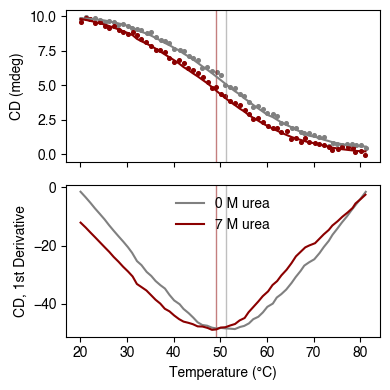

In [5]:
plot_CD(files[-3], files[-4], files[-1], files[-2], '004/fourU_WT_schwalbe.pdf')

In [6]:
def plot_spectra(file, file_85, savefile):
    spectra = pd.read_csv(file, sep = ',', skiprows=21, usecols = [0, 1], header = None)
    spectra = spectra[pd.to_numeric(spectra[0], errors='coerce').notnull()].astype(float)
    #plt.scatter(spectra[0], spectra[1])

    spectra_85 = pd.read_csv(file_85, sep = ',', skiprows=21, usecols = [0, 1], header = None)
    spectra_85 = spectra_85[pd.to_numeric(spectra_85[0], errors='coerce').notnull()].astype(float)

    spectra_smoothed = savgol_filter(spectra[1], window_length = 10, polyorder = 2, deriv = 0, delta = 1/fs)
    spectra_smoothed_85 = savgol_filter(spectra_85[1], window_length = 10, polyorder = 2, deriv = 0, delta = 1/fs)

    fig, ax = plt.subplots(figsize = (4, 4))

    plt.plot(spectra[0], spectra_smoothed, color = 'purple', label = '20°C')
    plt.plot(spectra[0], spectra_smoothed_85, color = 'darkgreen', label = '85°C')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('CD (mdeg)')
    plt.legend(frameon = False)
    plt.savefig(savefile)
    plt.show()
    
plot_spectra(files[0], files[3], 'A8C_spectra.pdf')

NameError: name 'fs' is not defined

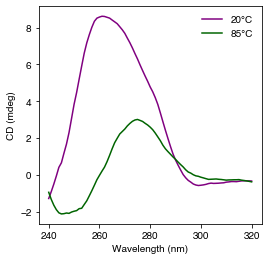

In [284]:
plot_spectra(files[4], files[7], 'WT_spectra.pdf')

Fitted parameters (Tm, dH, m_f, b_f, m_u, b_u): [ 5.45284183e+01  6.87229356e+00 -5.56756144e-03  7.61747093e-01
 -6.53358783e-02  1.13178239e+01]
Tm = 54.53 ± 0.23 °C


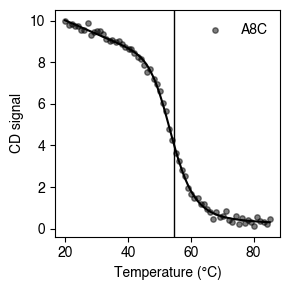

In [32]:
bkg = pd.read_csv(files[2], sep = ',', skiprows=16, usecols = [0, 1], header = None)
bkg = bkg[pd.to_numeric(bkg[0], errors='coerce').notnull()].astype(float)

data = pd.read_csv(files[1], sep = ',', skiprows=16, usecols = [0, 1], header = None)
data = data[pd.to_numeric(data[0], errors='coerce').notnull()].astype(float)

data[1] = data[1] - bkg[1]

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def two_state_melting_linear_baselines(x, Tm, dH, m_f, b_f, m_u, b_u):
    """
    Two-state melting model with linear baselines for CD data.

    Parameters:
    - x: Temperature values (array).
    - Tm: Melting temperature (scalar).
    - dH: Enthalpy change during melting (scalar).
    - m_f, b_f: Slope and intercept of the folded baseline (scalars).
    - m_u, b_u: Slope and intercept of the unfolded baseline (scalars).

    Returns:
    - y: CD values (array).
    """
    R = 0.008314  # Gas constant in kJ/(mol*K)
    
    # Linear baselines
    folded_baseline = m_f * x + b_f
    unfolded_baseline = m_u * x + b_u
    
    # Fraction unfolded (van 't Hoff equation)
    K = np.exp(-dH / R * (1 / Tm - 1 / x))
    fraction_unfolded = K / (1 + K)
    
    # CD signal
    y = folded_baseline + fraction_unfolded * (unfolded_baseline - folded_baseline)
    return y

def fit_cd_data_with_linear_baselines(temperatures, cd_values):
    """
    Fit CD melting data using the two-state model with linear baselines.

    Parameters:
    - temperatures: Array of temperatures (in Kelvin).
    - cd_values: Array of corresponding CD values.

    Returns:
    - popt: Optimal parameters for the fit (Tm, dH, m_f, b_f, m_u, b_u).
    - pcov: Covariance of the fit parameters.
    """
    # Initial guesses for parameters
    Tm_guess = np.mean(temperatures)
    dH_guess = 50  # Rough estimate in kJ/mol
    m_f_guess = 0  # Assume flat baseline initially
    b_f_guess = np.min(cd_values)  # Folded baseline near the minimum CD value
    m_u_guess = 0  # Assume flat baseline initially
    b_u_guess = np.max(cd_values)  # Unfolded baseline near the maximum CD value
    
    p0 = [Tm_guess, dH_guess, m_f_guess, b_f_guess, m_u_guess, b_u_guess]
    
    # Fit the data
    popt, pcov = curve_fit(two_state_melting_linear_baselines, temperatures, cd_values, p0=p0)
    return popt, pcov

temperatures = np.array(data[0])  # Convert to Kelvin
cd_values = np.array(data[1])

# Fit the synthetic data
popt, pcov = fit_cd_data_with_linear_baselines(temperatures, cd_values)
print("Fitted parameters (Tm, dH, m_f, b_f, m_u, b_u):", popt)

tm = popt[0]
tm_err = np.sqrt(np.diag(pcov))[0]
print(f"Tm = {tm:.2f} ± {tm_err:.2f} °C")

# Plot the data and fit
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(temperatures, cd_values, label="A8C", color="black", s=15, alpha=0.5)
ax.plot(temperatures, two_state_melting_linear_baselines(temperatures, *popt), label="", color="black")

# add vertical line at Tm + err
ax.axvline(tm, color='black', lw=1)
# shade error region

ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("CD signal")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('cd_A8C_no_urea_fit.pdf')
plt.show()

In [31]:
import numpy as np

def calculate_dG(T, fitted_params, param_errors=None):
    """
    Calculate Gibbs free energy change (Delta G) at a given temperature and estimate its error.

    Parameters:
    - T: Temperature of interest in Kelvin (float).
    - fitted_params: List of fitted parameters from the CD melting curve.
      [Tm, dH, m_f, b_f, m_u, b_u]
    - param_errors: List of errors (standard deviations) for the fitted parameters (optional).
      [Tm_error, dH_error, m_f_error, b_f_error, m_u_error, b_u_error]

    Returns:
    - dG: Gibbs free energy change at temperature T (float, in kJ/mol).
    - dG_error: Error in Delta G (float, in kJ/mol) if param_errors is provided; otherwise, None.
    """
    # Unpack fitted parameters
    Tm, dH, m_f, b_f, m_u, b_u = fitted_params

    # Calculate Delta G using the thermodynamic equation
    dG = dH * (1 - (T / Tm))

    # If errors are provided, propagate uncertainty
    dG_error = None
    if param_errors is not None:
        Tm_error, dH_error, _, _, _, _ = param_errors

        # Error propagation formula for Delta G
        dG_error = np.sqrt(
            (1 - (T / Tm))**2 * dH_error**2 +
            (dH * T / Tm**2)**2 * Tm_error**2
        )

    return dG, dG_error

# Fitted parameters: [Tm (K), dH (kJ/mol), m_f, b_f, m_u, b_u]
fitted_params = popt
# Errors in the fitted parameters: [Tm_error, dH_error, m_f_error, b_f_error, m_u_error, b_u_error]
param_errors = np.sqrt(np.diag(pcov))  # Standard deviation (errors) of the fitted parameters
print(param_errors)
# Temperature of interest: 20°C = 293.15 K
T = 293.15

# Calculate Delta G and its error
dG, dG_error = calculate_dG(T, fitted_params, param_errors)
print(f"\u0394G at {T} K: {dG:.2f} kJ/mol")
if dG_error is not None:
    print(f"Error in \u0394G: {dG_error:.2f} kJ/mol")


[0.22821502 0.3185422  0.00719063 0.56853383 0.00417207 0.13433147]
ΔG at 293.15 K: -30.07 kJ/mol
Error in ΔG: 1.40 kJ/mol
